In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer

from collections import defaultdict

import re
import string
import time
import pickle
import warnings
from collections import Counter
warnings.filterwarnings('ignore')

Read configuration from FakeNewsModel.ini configuration file

In [2]:
import configparser

current_time = str(time.time())

config = configparser.ConfigParser()
config.read('FakeNewsModel.ini')
print(f'Configuration Sections: {config.sections()}')

file_true = config['DATASET']['TrueFile']
file_fake = config['DATASET']['FakeFile']

Proc_show_headinfo    = config['EDA']['SHOW_HeadInfo'    ]
Proc_showbasic_info   = config['EDA']['SHOW_BasicInfo'   ]
Proc_showmissing      = config['EDA']['SHOW_Missing'     ]
Proc_dropna           = config['EDA']['DROP_NAValues'    ]
Proc_showcommon_words = config['EDA']['SHOW_COMMON_WORDS']
Proc_show_wordcloud   = config['EDA']['SHOW_WORD_CLOUD'  ]

n_common_words  = (int)( config['EDA']['SHOW_n_COMMON_WORDS'])
print(f'n_common_words: {n_common_words}')

print(f'Proc_showbasic_info: {Proc_showbasic_info}, Proc_showmissing: {Proc_showmissing}, Proc_dropna: {Proc_dropna}')
print(f'Proc_showcommon_words: {Proc_showcommon_words}, Proc_show_wordcloud: {Proc_show_wordcloud}')

Configuration Sections: ['DATASET', 'FEATURE_PROCESSING', 'EDA', 'PROCESS', 'MODELS']
n_common_words: 50
Proc_showbasic_info: TRUE, Proc_showmissing: TRUE, Proc_dropna: TRUE
Proc_showcommon_words: TRUE, Proc_show_wordcloud: TRUE


In [3]:
# Text operation to remove escape characters
# Remove urls and escape characters
def wordopt( text ):
    text = text.lower()
    text = re.sub('\[.*?\]','',text)
    text = re.sub('\\W', ' ',  text)
    text = re.sub('https?://\S+|www\.\S+','',text)
    text = re.sub('<.*?>+','',text)
    text = re.sub('[%s]' % re.escape(string.punctuation),'',text)
    text = re.sub('\n','',text)
    text = re.sub('\w*\d\w*','',text)
    return text

In [4]:
# input the true and fake data files, 
# Extract 'publisher' info from the first 30 characters in the text
# Create new 'publisher' feature column

data_fake = pd.read_csv( file_fake )
data_true = pd.read_csv( file_true )

# Assigning Classes to the Dataset
data_fake['class'] = 0
data_true['class'] = 1

sysLog = [] 

In [5]:
# Basic EDA on dataset
if Proc_show_headinfo: 
    print(f'*****  Fake Data  *****')
    print(f'{data_fake.head()}')
    print(f'\n\n')
    print(f'*****  True Data  *****')
    print(f'{data_true.head()}')
    
    

*****  Fake Data  *****
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  class  
0  December 31, 2017      0  
1  December 31, 2017      0  
2  December 30, 2017      0  
3  December 29, 2017      0  
4  December 25, 2017      0  



*****  True Data  *****
                                               

In [6]:
if Proc_showbasic_info:
    print(f'*****  DataSet Basic Info  *****')
    print(f'Fake Set: {data_fake.shape}')
    print(f'{data_fake.info()}')
    print(f'{data_fake.describe()}')
    
    print(f'True Set: {data_true.shape}')
    print(f'{data_true.info()}')
    print(f'{data_true.describe()}')
    
if Proc_showmissing:
    print(f'Fake News null: {data_fake.isnull().sum()}')
    print(f'True News null: {data_true.isnull().sum()}')


*****  DataSet Basic Info  *****
Fake Set: (23481, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
 4   class    23481 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 917.4+ KB
None
         class
count  23481.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
True Set: (21417, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
 4   class    21417 non-null  int64 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fkao9\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fkao9\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\fkao9\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fkao9\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


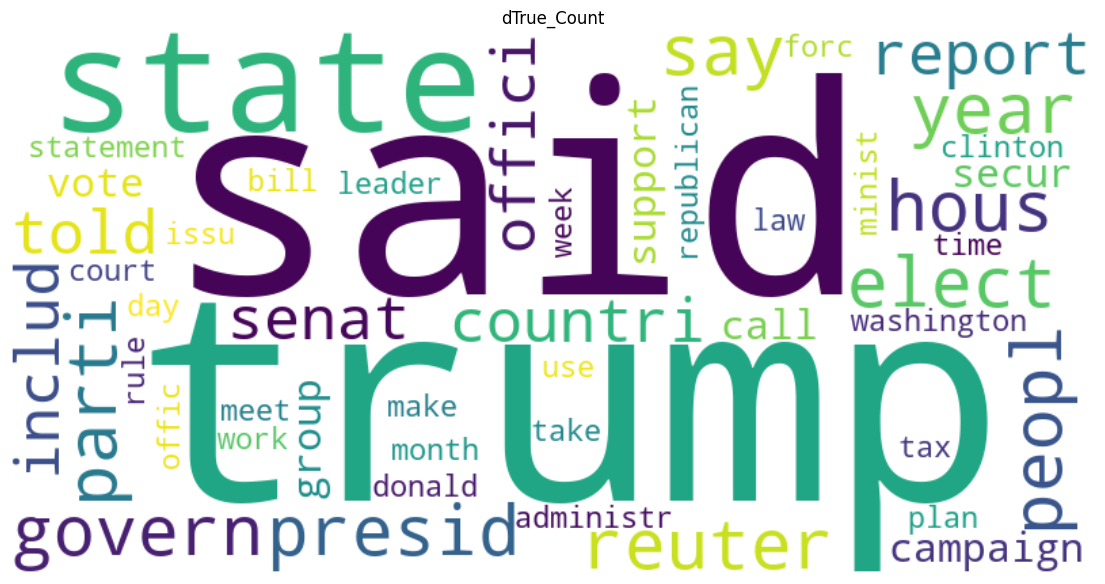

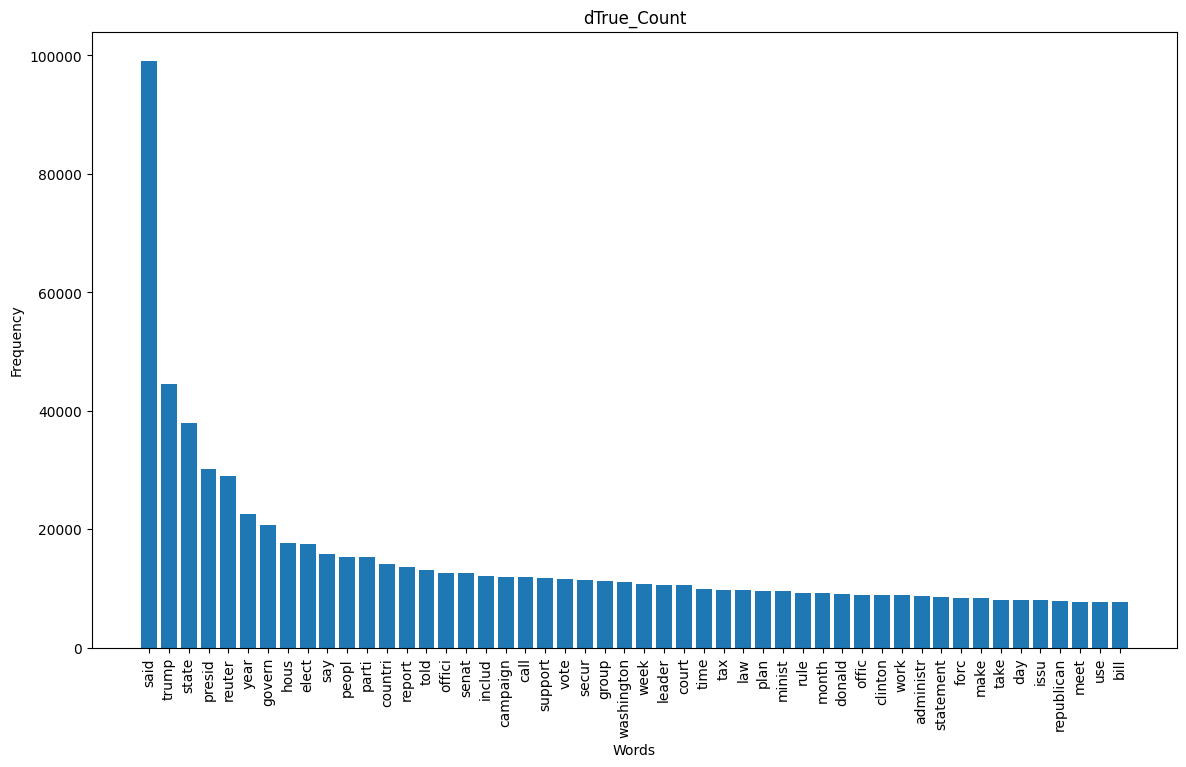

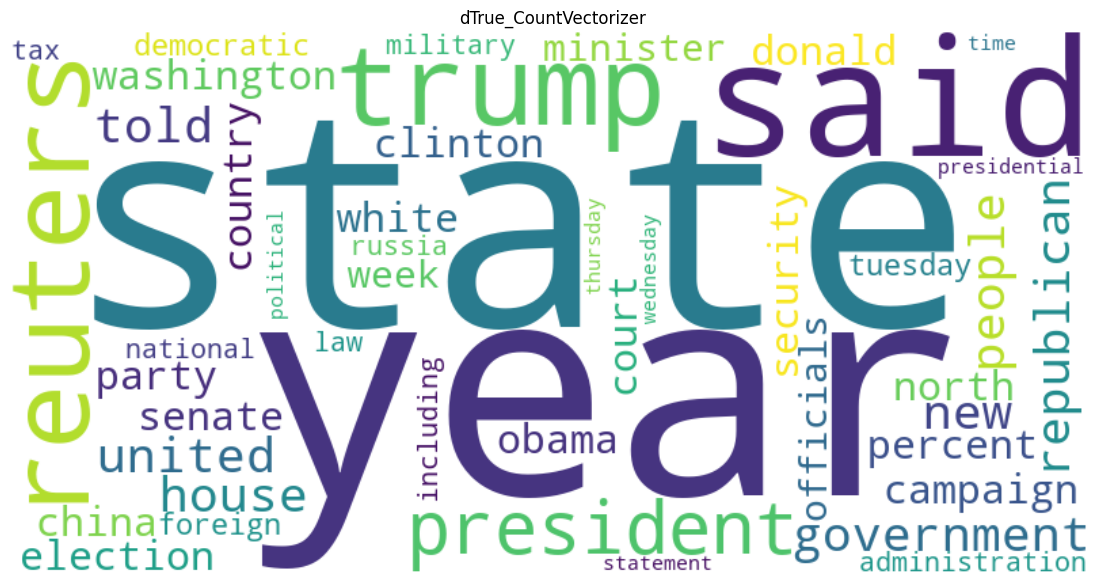

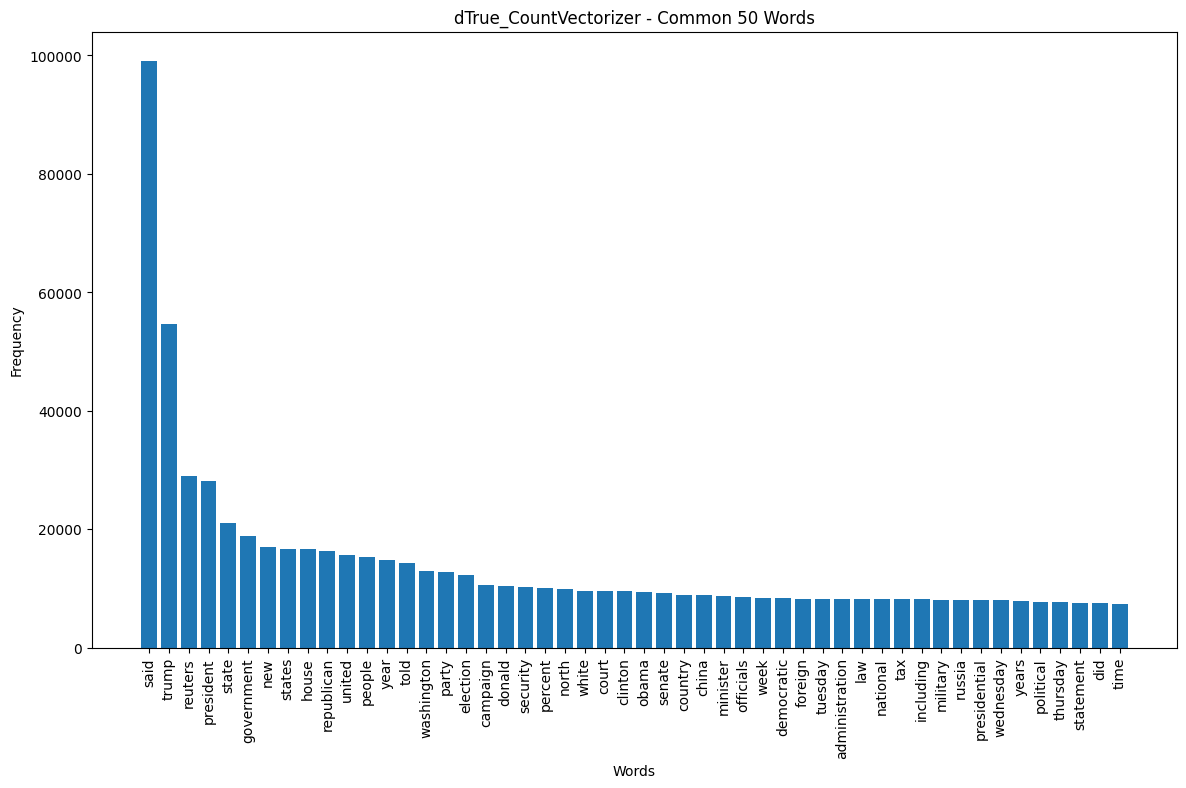

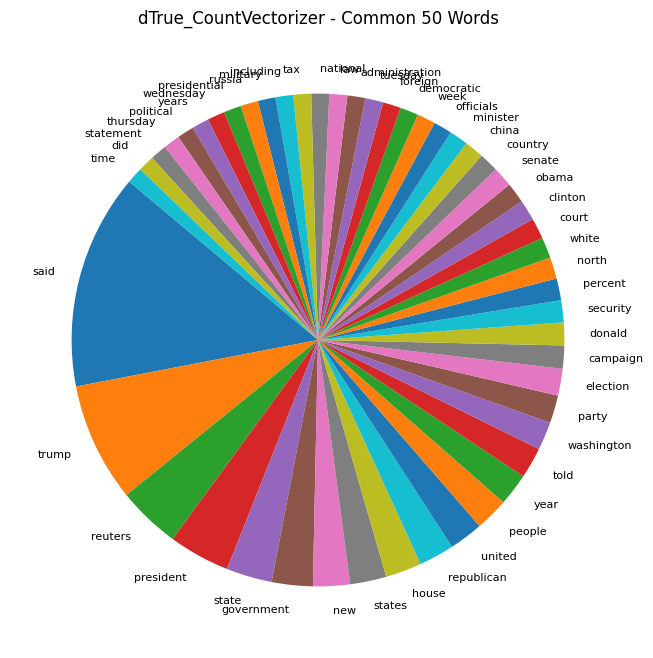

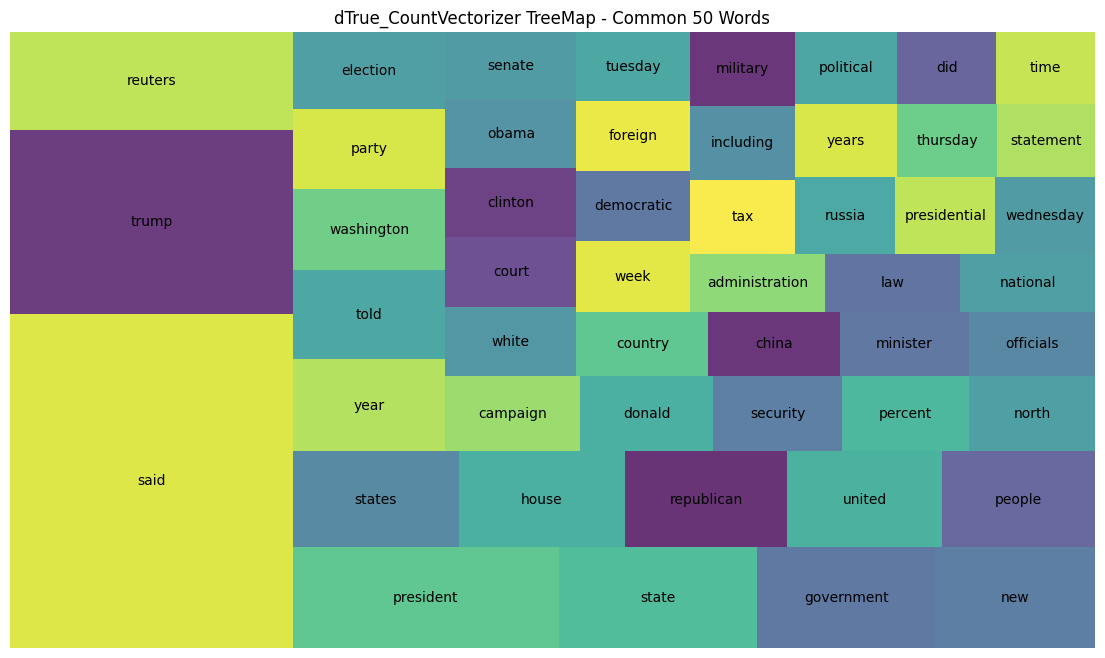

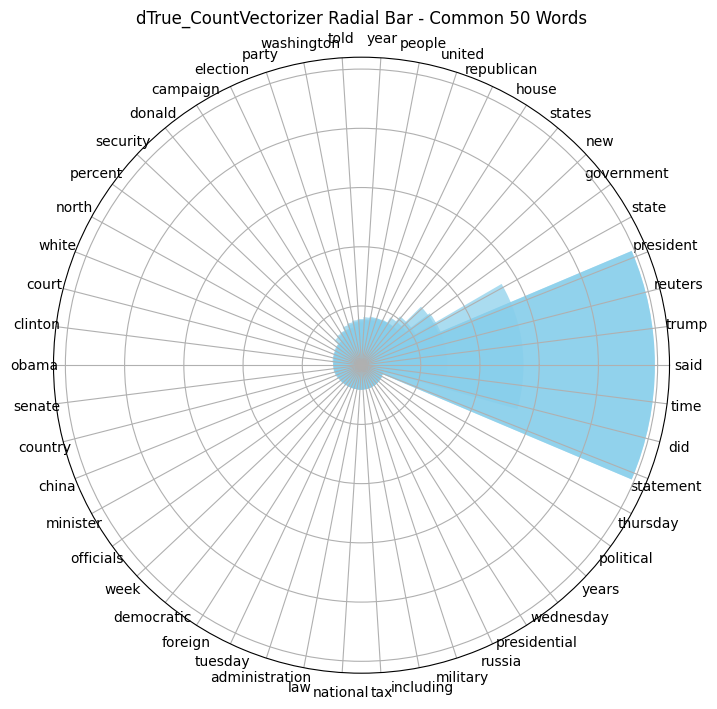

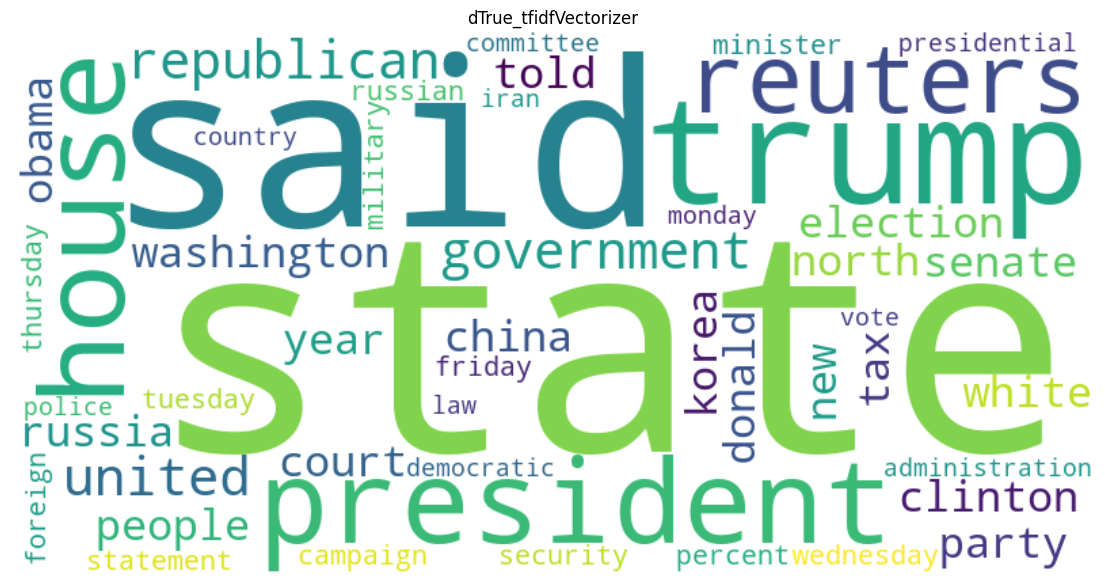

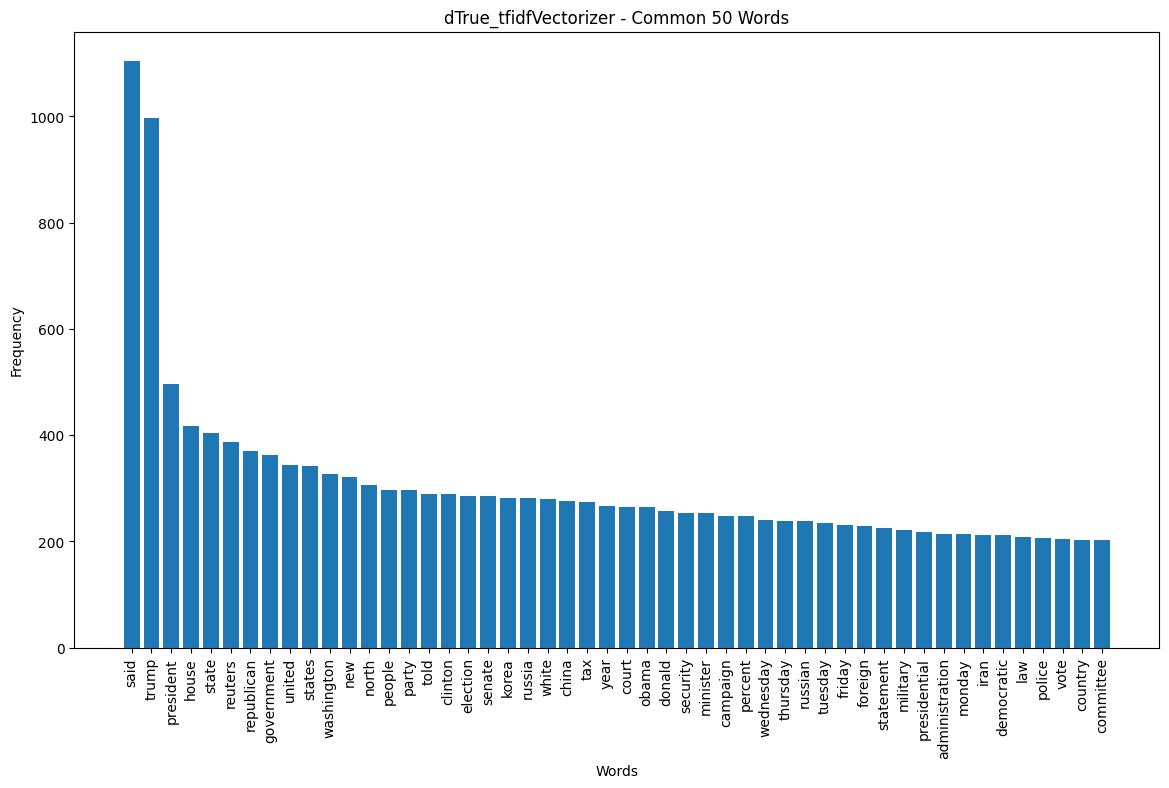

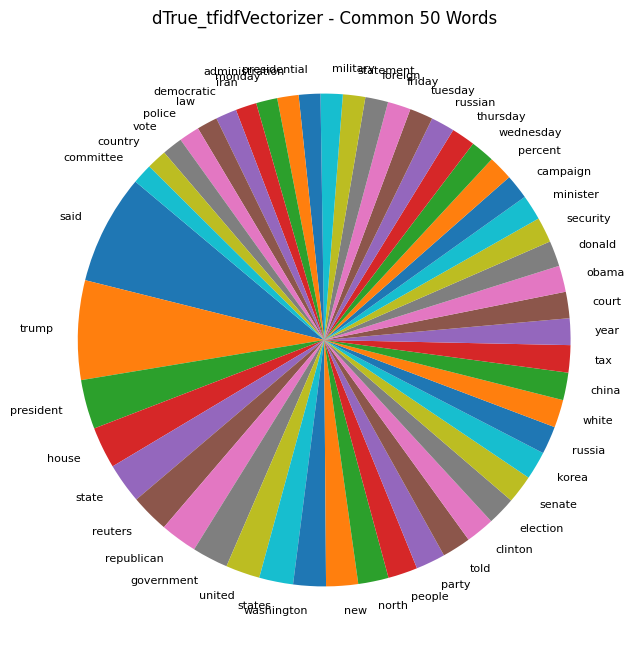

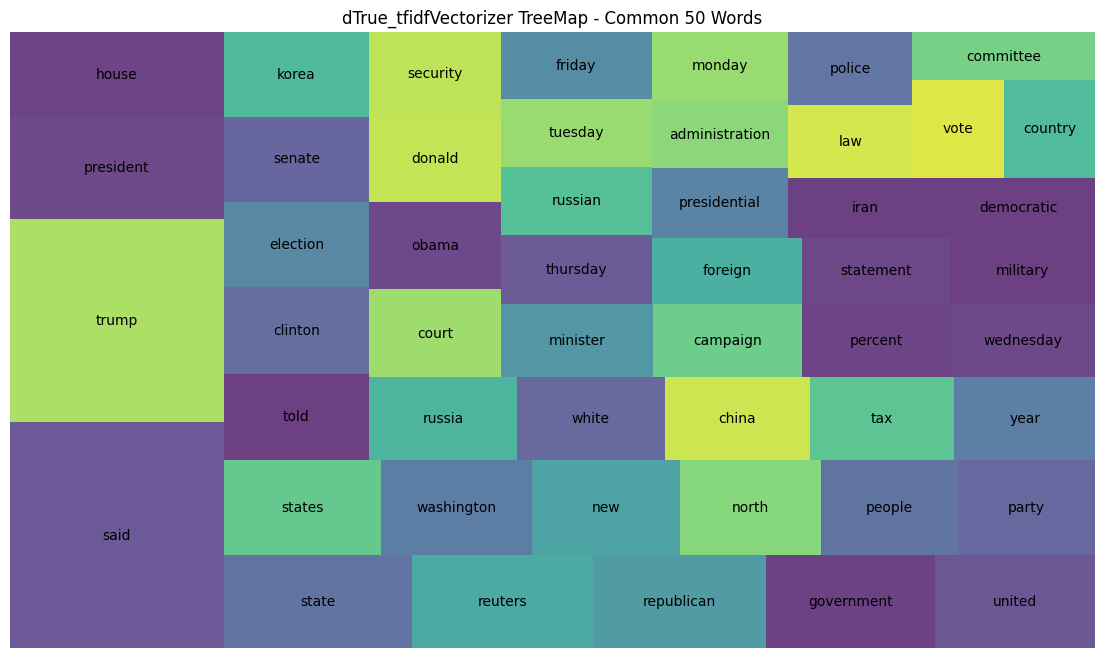

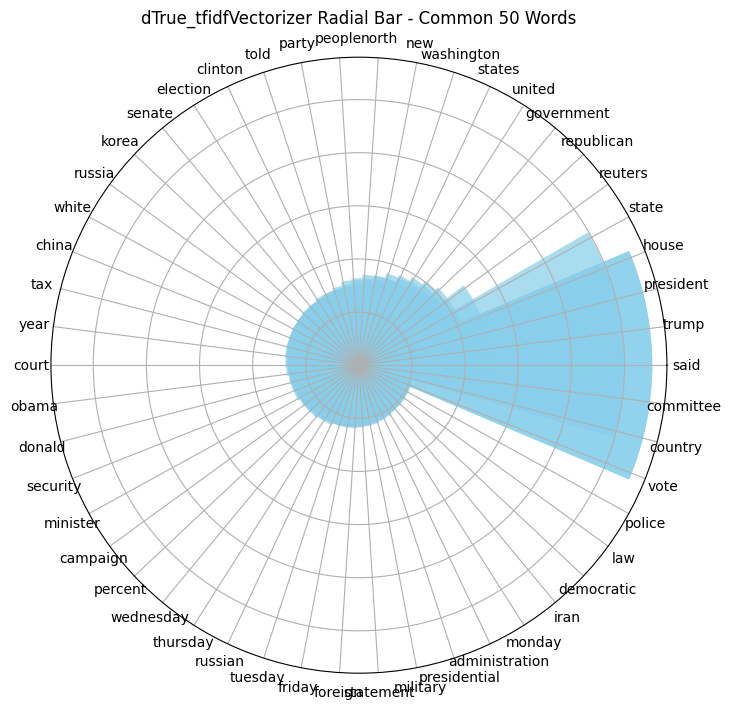

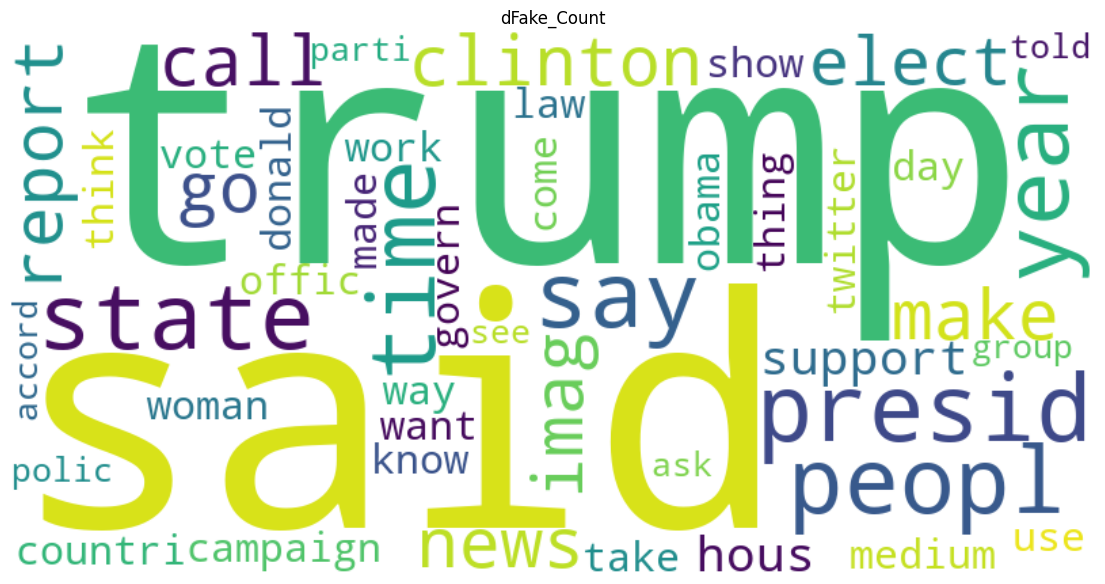

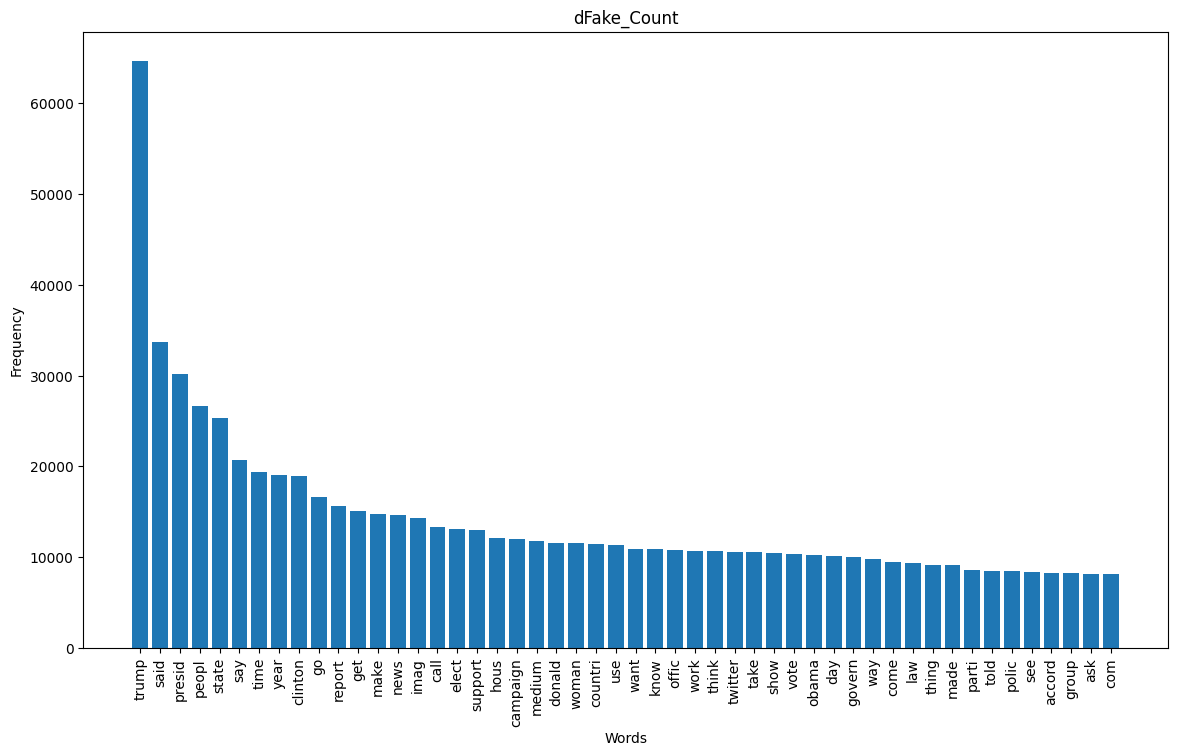

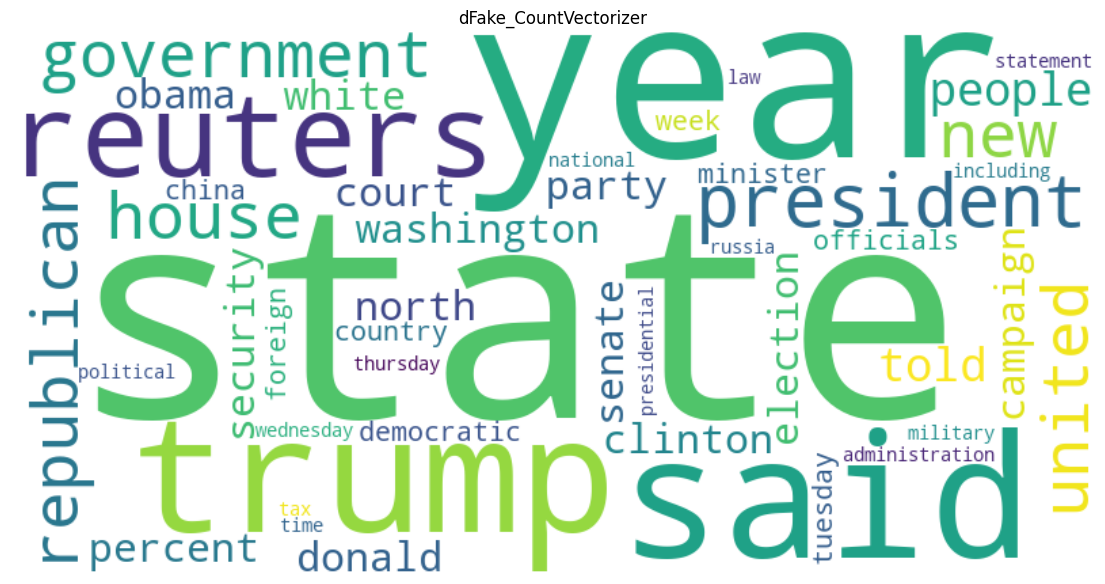

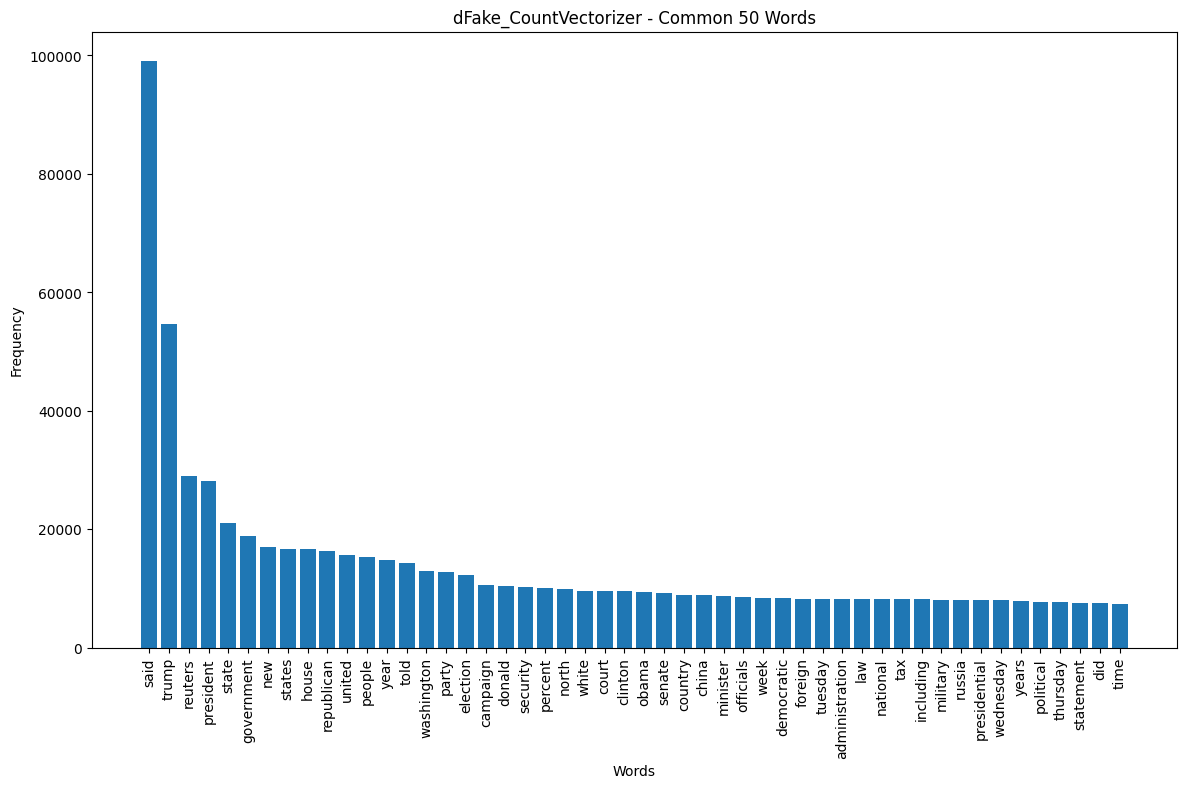

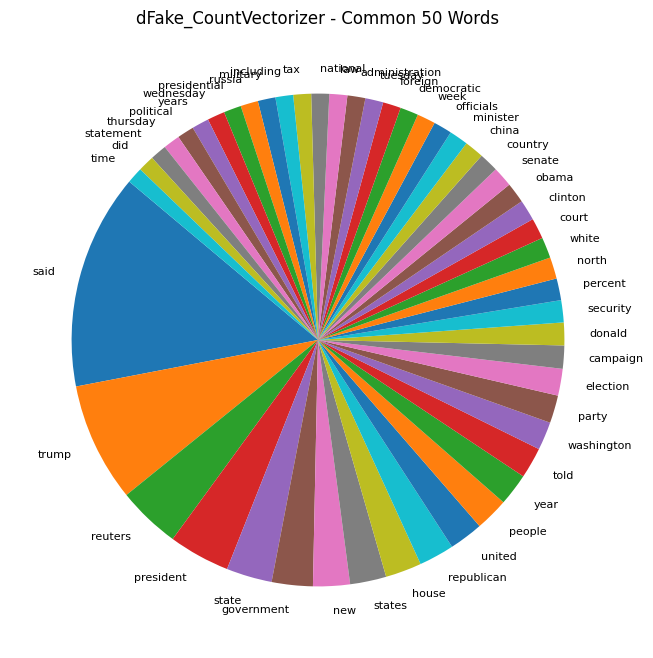

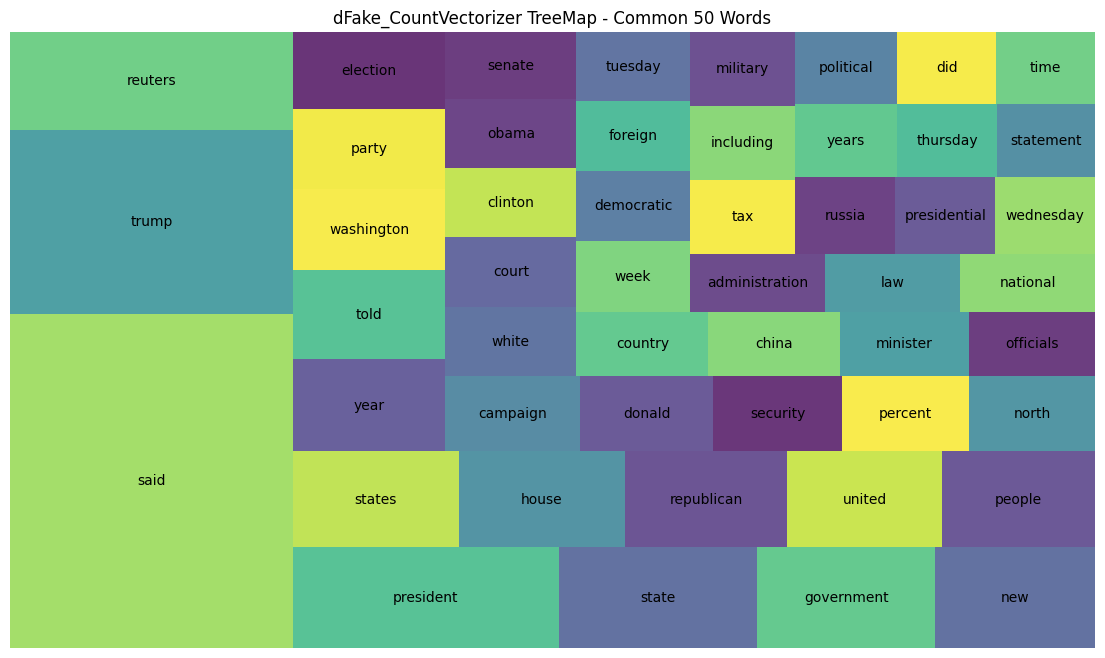

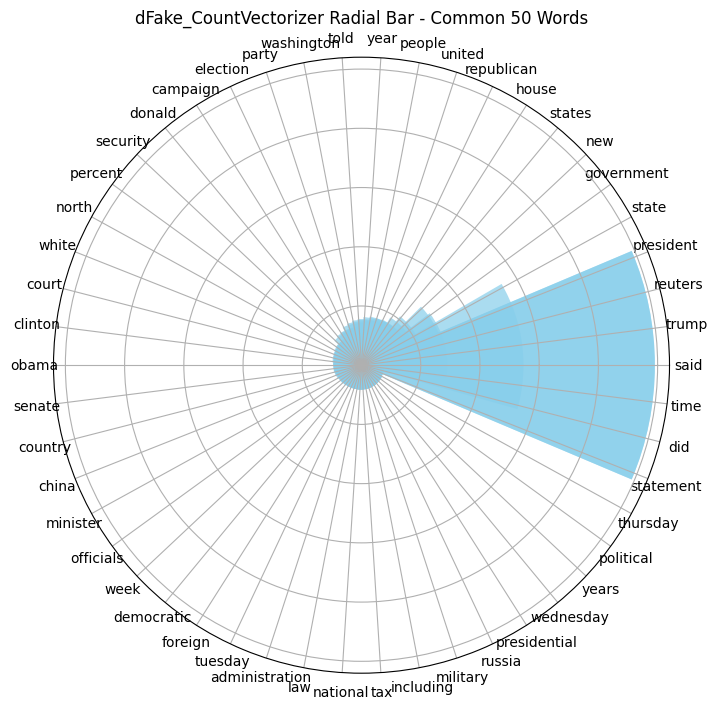

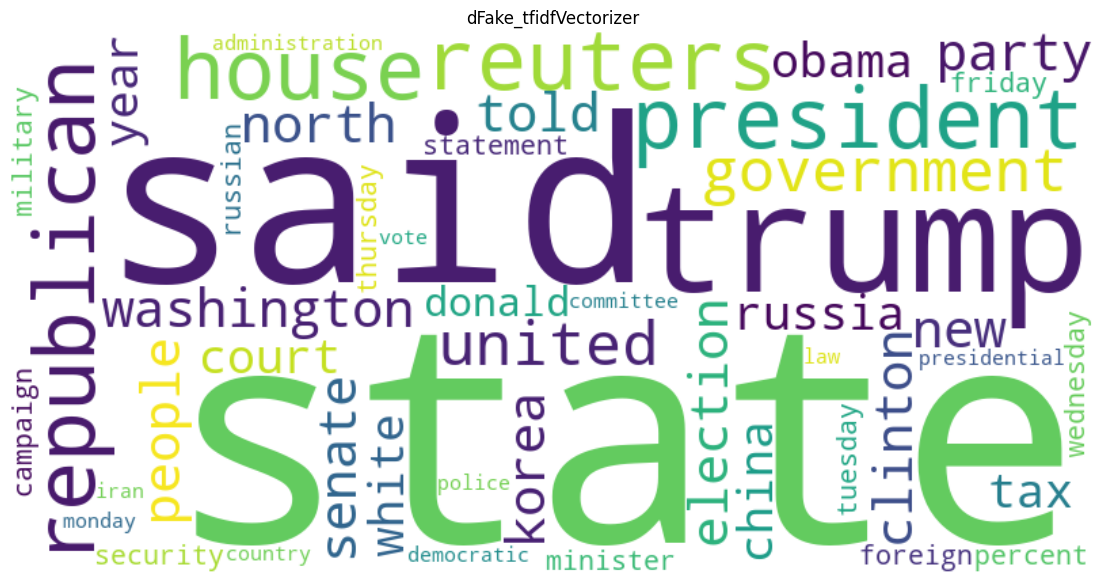

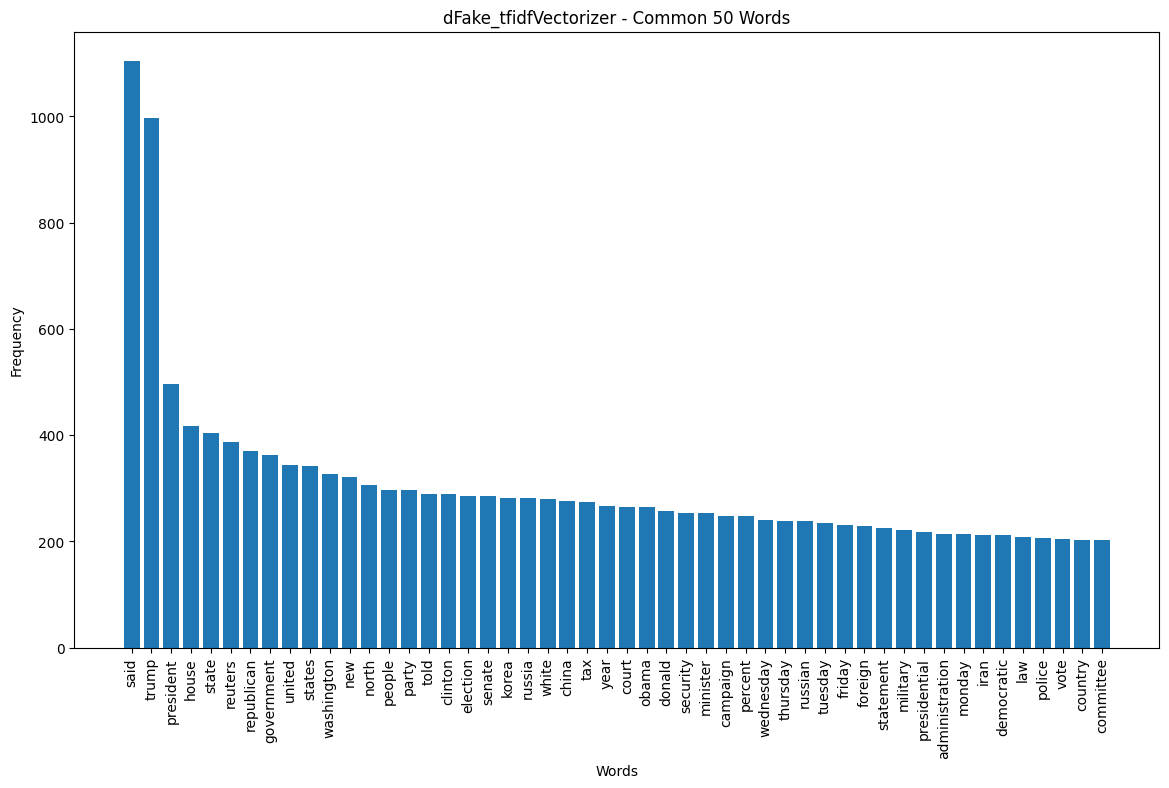

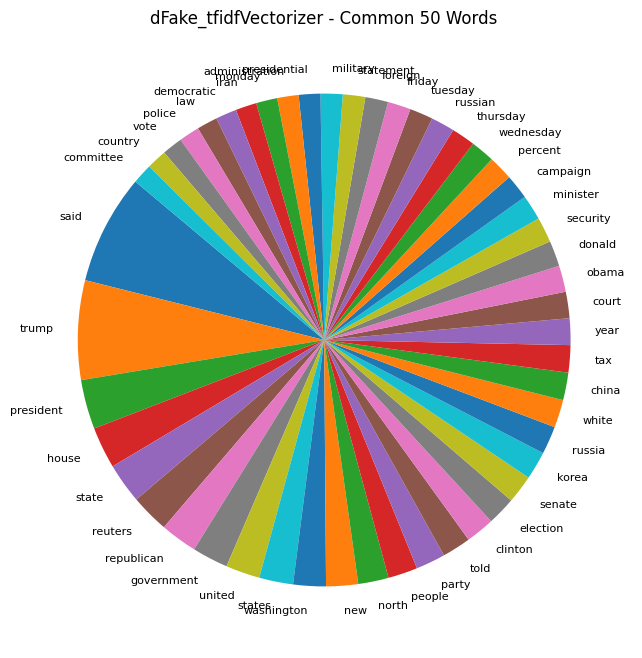

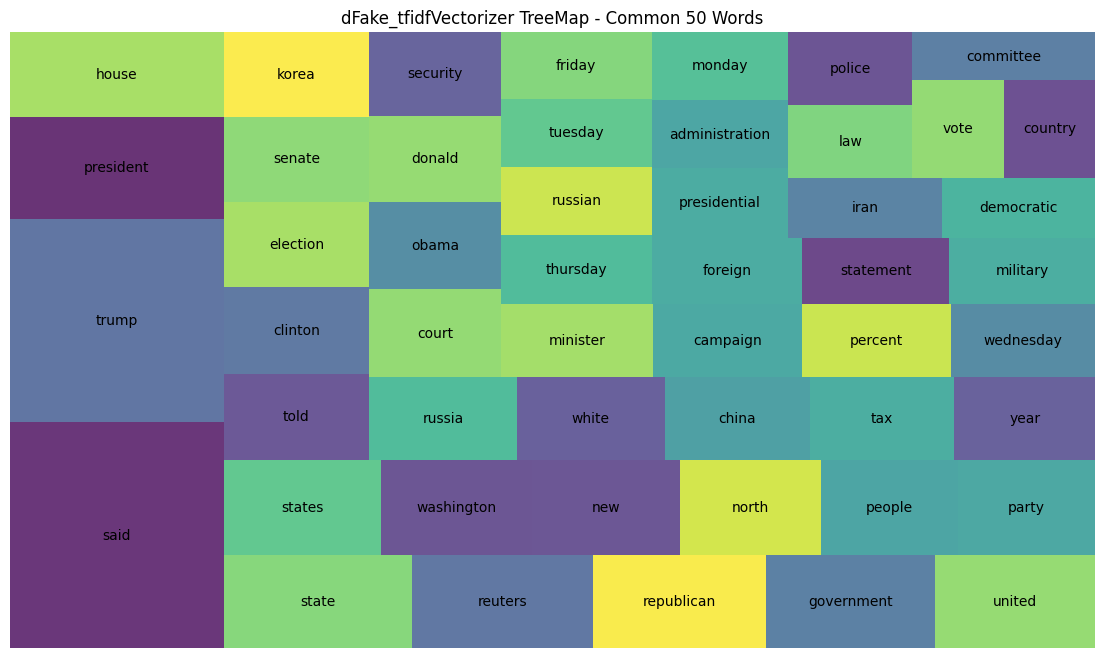

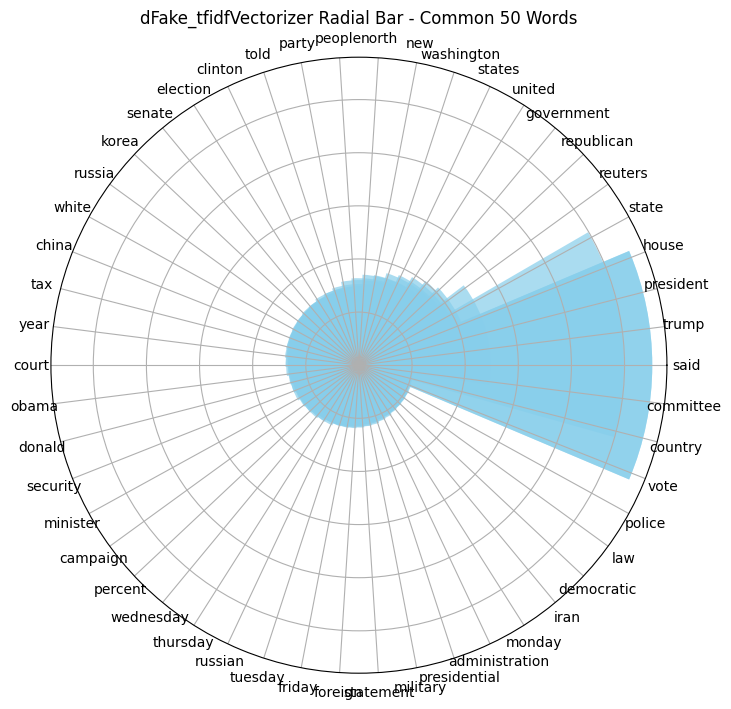

In [7]:
#####################################################################################
#  Functions for plotting tokenization and vectorization results                    #
#####################################################################################
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import pos_tag
import nltk

from collections import Counter
from wordcloud import WordCloud

figsize = (14,8)
# Download stopwords if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

def plot_wordFreqBar( common_words, tagname ):
    words, counts = zip(*common_words)
    plt.figure(figsize=figsize)
    plt.bar(words, counts)
    plt.xticks(rotation=90)
    plt.title(f'{tagname}')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.show()

def plot_wordFreqPie( common_words, tagname ):
    # Plot pie chart for the most common words
    words, counts = zip(*common_words[:n_common_words])  # Top words for better visualization
    plt.figure(figsize=figsize)
    plt.pie(counts, labels=words, startangle=140,textprops={'fontsize': 8})
    plt.title(f'{tagname}')
    plt.show()

def plot_wordFreqTreemap( common_words, tagname ):    
    import squarify
    # Prepare data for treemap
    words, counts = zip(*common_words)
    sizes = [count for count in counts]

    # Plot treemap
    plt.figure(figsize=figsize)
    squarify.plot(sizes=sizes, label=words, alpha=0.8)
    plt.axis('off')
    plt.title(f'{tagname}')
    plt.show()

def plot_wordFreqCircularPacking( common_words, tagname ):
    import plotly.express as px
    # Prepare data for circular packing
    df_common_words = pd.DataFrame(common_words, columns=['word', 'count'])
    n_words = len(df_common_words['word'])
    # Plot circular packing
    fig = px.treemap(df_common_words, path=['word'], values='count', title=f'{tagname}')
    fig.update_traces(marker=dict(colorscale='Blues'))
    fig.show()

def plot_wordFreqRadialBar( common_words, tagname ):
    # Prepare data for radial bar chart
    words, counts = zip(*common_words)
    angles = np.linspace(0, 2 * np.pi, len(words), endpoint=False).tolist()
    counts += counts[:1]
    angles += angles[:1]

    # Plot radial bar chart
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(polar=True))
    ax.bar(angles, counts, color='skyblue', alpha=0.7)
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(words, rotation=90)
    plt.title(f'{tagname}')
    plt.show()
  
def plot_WordCloud( common_words, tagname ):
    filename = tagname + '.jpg'
    common_words_list = [ word for word,count in common_words ]
    all_words = ' '.join(common_words_list)
    wordcloud_ = WordCloud(width=800, height=400, background_color='white').generate(all_words)

    # Display the word cloud
    plt.figure(figsize=figsize)
    plt.imshow(wordcloud_, interpolation='bilinear')
    plt.axis('off')
    plt.title( tagname )
    plt.savefig( filename )
    plt.show()
    
def processWords( df, position_tags ):
    df['text'] = df['text'].apply(wordopt)            # Remove known artifacts from document
    all_text   = ' '.join(df['text'].astype(str))     # Stringize all words for tokenization
    words = word_tokenize(all_text)
    stop_words     = set(stopwords.words('english'))  # Remove stop words
    filtered_words = [word for word in words if word not in stop_words]
    pos_tags = pos_tag(filtered_words)                # Embed position tags to words
    # Remove/filter words that are not in the targeted position tags
    filtered_words = [word for word, tag in pos_tags if tag in position_tags]
    stemmer    = PorterStemmer()
    lemmatizer = WordNetLemmatizer()

    stemmed_words    = [stemmer.stem(word) for word in filtered_words]
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stemmed_words]

    return df, lemmatized_words

def do_WordVectorizer( df, vectorizer_model, tagname ):
    vectorizer = vectorizer_model(stop_words='english')
    X = vectorizer.fit_transform(df['text'])

    # Sum up the counts of each vocabulary word
    word_counts_vectorizer = X.sum(axis=0).A1
    vocab = vectorizer.get_feature_names_out()
    word_freq = dict(zip(vocab, word_counts_vectorizer))

    # Get the 100 most common words using CountVectorizer
    common_words_vectorizer = Counter(word_freq).most_common( n_common_words )
    plot_WordCloud( common_words_vectorizer, f'{tagname}')
    plot_wordFreqBar( common_words_vectorizer, f'{tagname} - Common {n_common_words} Words' )
    plot_wordFreqPie( common_words_vectorizer, f'{tagname} - Common {n_common_words} Words' )
    plot_wordFreqTreemap( common_words_vectorizer, f'{tagname} TreeMap - Common {n_common_words} Words' )
    plot_wordFreqCircularPacking( common_words_vectorizer, f'{tagname} Circular Packing - Common {n_common_words} Words' )
    plot_wordFreqRadialBar( common_words_vectorizer, f'{tagname} Radial Bar - Common {n_common_words} Words' )

def do_WordEDA( df, important_pos_tags, tagname ):    
    df, lemmatized_words = processWords( df, important_pos_tags )

    # Count the frequency of each word
    word_counts  = Counter(lemmatized_words)
    common_words = word_counts.most_common( n_common_words )
    plot_WordCloud  ( common_words, f'{tagname}_Count' )        # plot wordCloud
    plot_wordFreqBar( common_words, f'{tagname}_Count' )                    # plot wordFreq Bar

    do_WordVectorizer( data_true, CountVectorizer, f'{tagname}_CountVectorizer' )  # Count/BagOfWord Vectorizer
    do_WordVectorizer( data_true, TfidfVectorizer, f'{tagname}_tfidfVectorizer' )  # tfidf Vectorizer   

important_pos_tags = {'NN', 'NNS', 'NNP', 'NNPS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'}
do_WordEDA( data_true, important_pos_tags, 'dTrue')
do_WordEDA( data_fake, important_pos_tags, 'dFake')



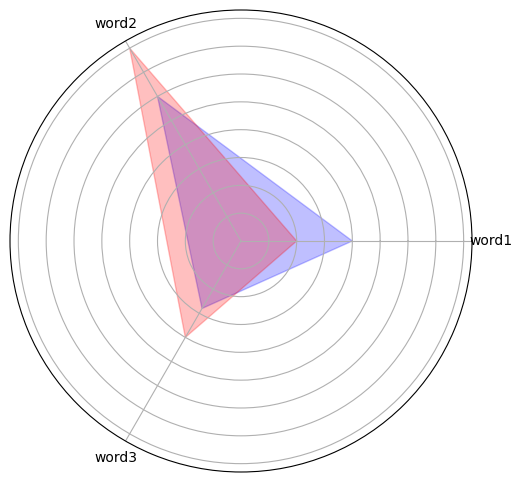

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Example data
words_set1 = {'word1': 10, 'word2': 15, 'word3': 7}
words_set2 = {'word1': 5, 'word2': 20, 'word3': 10}

labels = list(words_set1.keys())
values1 = list(words_set1.values())
values2 = list(words_set2.values())

# Number of variables
num_vars = len(labels)

# Compute angle for each bar
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is circular, so we need to "complete the loop"
values1 += values1[:1]
values2 += values2[:1]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

ax.fill(angles, values1, color='blue', alpha=0.25)
ax.fill(angles, values2, color='red', alpha=0.25)

ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

plt.show()
